In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

# colormap stuff for gradient plotting
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F200W']
filters = ['m_jwst_F115W', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

/scratch/wyz5rge/synthetic-hr/interpolator.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  w1 = (np.power(10, age_arr[a2]) / 1000000 - age) / (np.power(10, age_arr[a2]) / 1000000 - np.power(10, age_arr[a1]) / 1000000)
/scratch/wyz5rge/synthetic-hr/interpolator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  s_lum = w1 * s1[1] + w2 * s2[1]
/scratch/wyz5rge/synthetic-hr/interpolator.py:100: RuntimeWarning: invalid value encountered in double_scalars
  s_teff = w1 * s1[2] + w2 * s2[2]
/scratch/wyz5rge/synthetic-hr/interpolator.py:101: RuntimeWarning: invalid value encountered in double_scalars
  s_logg = w1 * s1[3] + w2 * s2[3]
/scratch/wyz5rge/synthetic-hr/interpolator.py:102: RuntimeWarning: invalid value encountered in double_scalars
  s_filt1 = w1 * s1[4] + w2 * s2[4]
/scratch/wyz5rge/synthetic-hr/interpolator.py:103: RuntimeWarning: invalid value encountered in double_scalars
  s_filt2 = w1 * s1[5] + w2 * s2[5]
/scratch/wyz5rge/synthetic-hr/

Changing to logg=5.00 for T=  1870 logg=3.98
Isochrone generation took 1.067942 s.
Making photometry for isochrone: log(t) = 6.78  AKs = 0.00  dist = 410
     Starting at:  2024-05-10 05:53:46.687987   Usually takes ~5 minutes
Starting filter: jwst,F115W   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1870 K  m_jwst_F115W = 20.17
Starting filter: jwst,F200W   Elapsed time: 0.49 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1870 K  m_jwst_F200W = 18.65
      Time taken: 1.00 seconds


/scratch/wyz5rge/synthetic-hr/interpolator.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  w1 = (np.power(10, age_arr[a2]) / 1000000 - age) / (np.power(10, age_arr[a2]) / 1000000 - np.power(10, age_arr[a1]) / 1000000)
/scratch/wyz5rge/synthetic-hr/interpolator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  s_lum = w1 * s1[1] + w2 * s2[1]
/scratch/wyz5rge/synthetic-hr/interpolator.py:100: RuntimeWarning: invalid value encountered in double_scalars
  s_teff = w1 * s1[2] + w2 * s2[2]
/scratch/wyz5rge/synthetic-hr/interpolator.py:101: RuntimeWarning: invalid value encountered in double_scalars
  s_logg = w1 * s1[3] + w2 * s2[3]
/scratch/wyz5rge/synthetic-hr/interpolator.py:102: RuntimeWarning: invalid value encountered in double_scalars
  s_filt1 = w1 * s1[4] + w2 * s2[4]
/scratch/wyz5rge/synthetic-hr/interpolator.py:103: RuntimeWarning: invalid value encountered in double_scalars
  s_filt2 = w1 * s1[5] + w2 * s2[5]


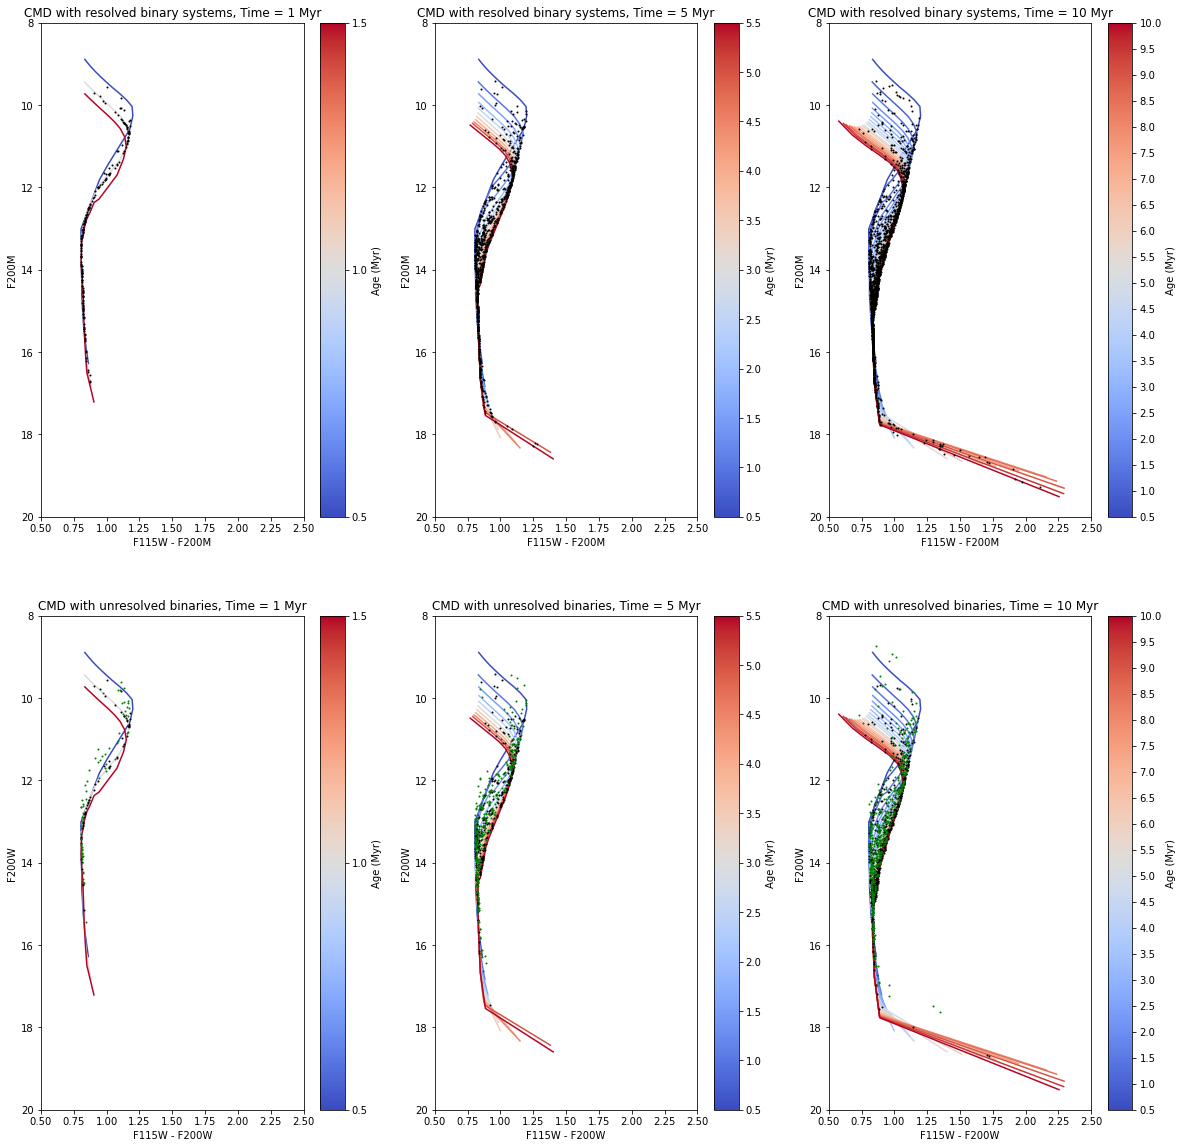

In [3]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff001_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [1, 5, 10]

xlim_min = 0.5
xlim_max = 2.5
ylim_min = 8
ylim_max = 20

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, 3, t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title('CMD with resolved binary systems, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, 3, t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title('CMD with unresolved binaries, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

In [35]:
# measure spread on CMD with resolved binaries

# Bounding box range 
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 13
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        if color_index < companions[i][3] - companions[i][4] < color_index + color_step and mag_min < companions[i][4] < mag_max:
            mag_bin.append(companions[i][4])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)

Standard deviation for color index 0.85 to 0.90: 0.18
Standard deviation for color index 0.90 to 0.95: 0.20
Standard deviation for color index 0.95 to 1.00: 0.20
Standard deviation for color index 1.00 to 1.05: 0.19
Standard deviation for color index 1.05 to 1.10: 0.25
Average standard deviation: 0.20369544400601206


In [40]:
# Bounding box range 
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 13
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        if color_index < stars[i + first_binary][3] - stars[i + first_binary][4] < color_index + color_step and mag_min < unresolved_binaries[i][1] < mag_max:
            mag_bin.append(unresolved_binaries[i][1])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)

Standard deviation for color index 0.85 to 0.90: 0.27
Standard deviation for color index 0.90 to 0.95: 0.22
Standard deviation for color index 0.95 to 1.00: 0.32
Standard deviation for color index 1.00 to 1.05: 0.21
Standard deviation for color index 1.05 to 1.10: 0.28
Average standard deviation: 0.2604378204482827


/scratch/wyz5rge/synthetic-hr/interpolator.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  w1 = (np.power(10, age_arr[a2]) / 1000000 - age) / (np.power(10, age_arr[a2]) / 1000000 - np.power(10, age_arr[a1]) / 1000000)
/scratch/wyz5rge/synthetic-hr/interpolator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  s_lum = w1 * s1[1] + w2 * s2[1]
/scratch/wyz5rge/synthetic-hr/interpolator.py:100: RuntimeWarning: invalid value encountered in double_scalars
  s_teff = w1 * s1[2] + w2 * s2[2]
/scratch/wyz5rge/synthetic-hr/interpolator.py:101: RuntimeWarning: invalid value encountered in double_scalars
  s_logg = w1 * s1[3] + w2 * s2[3]
/scratch/wyz5rge/synthetic-hr/interpolator.py:102: RuntimeWarning: invalid value encountered in double_scalars
  s_filt1 = w1 * s1[4] + w2 * s2[4]
/scratch/wyz5rge/synthetic-hr/interpolator.py:103: RuntimeWarning: invalid value encountered in double_scalars
  s_filt2 = w1 * s1[5] + w2 * s2[5]
/scratch/wyz5rge/synthetic-hr/

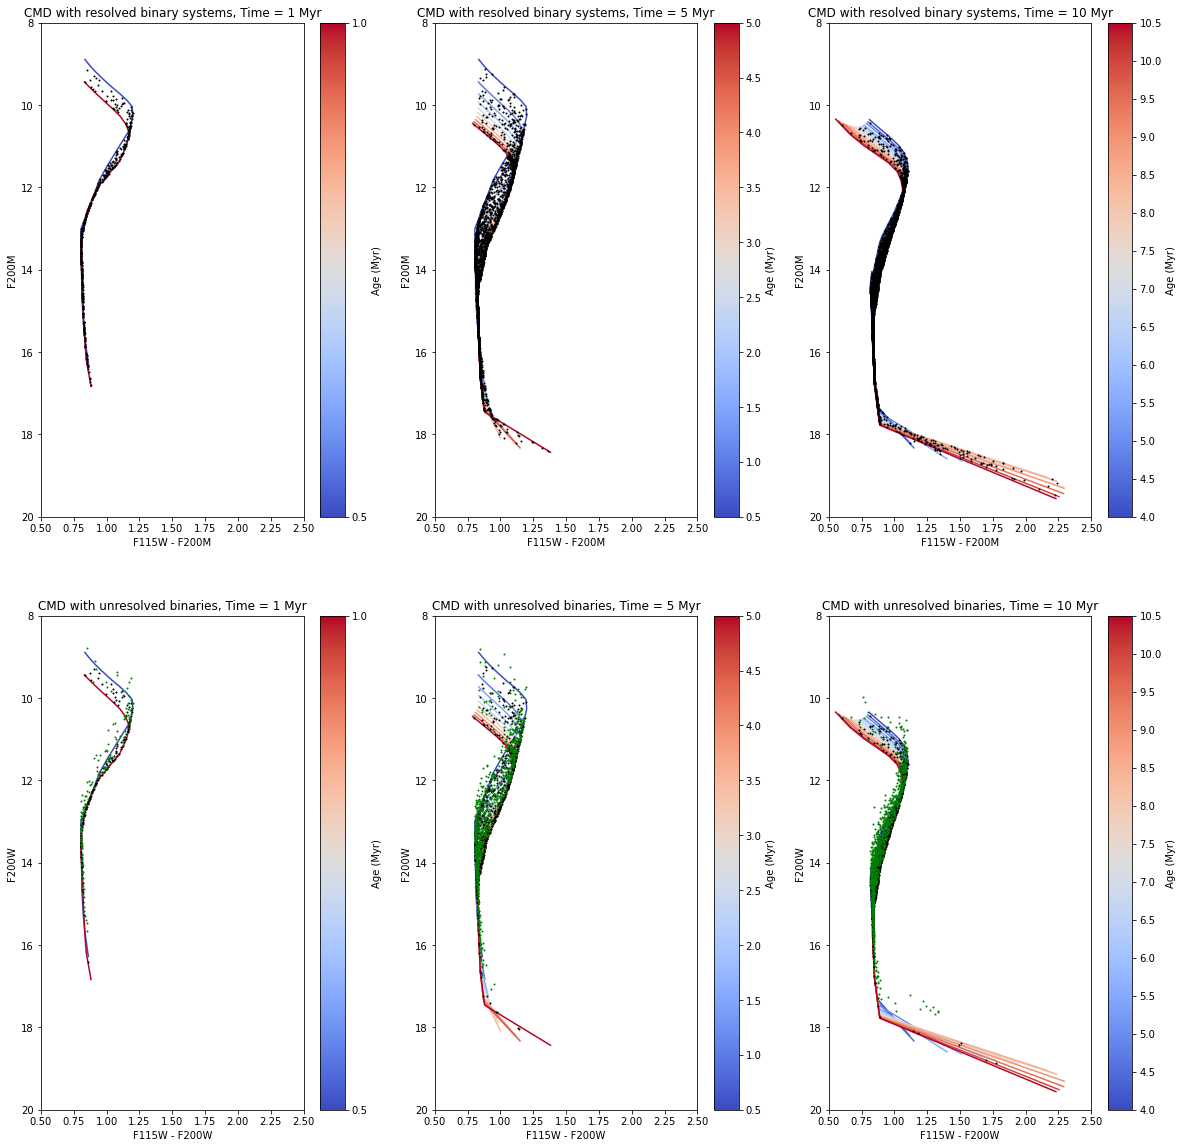

In [4]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff003_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [1, 5, 10]

xlim_min = 0.5
xlim_max = 2.5
ylim_min = 8
ylim_max = 20

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, 3, t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title('CMD with resolved binary systems, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, 3, t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title('CMD with unresolved binaries, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

/scratch/wyz5rge/synthetic-hr/interpolator.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  w1 = (np.power(10, age_arr[a2]) / 1000000 - age) / (np.power(10, age_arr[a2]) / 1000000 - np.power(10, age_arr[a1]) / 1000000)
/scratch/wyz5rge/synthetic-hr/interpolator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  s_lum = w1 * s1[1] + w2 * s2[1]
/scratch/wyz5rge/synthetic-hr/interpolator.py:100: RuntimeWarning: invalid value encountered in double_scalars
  s_teff = w1 * s1[2] + w2 * s2[2]
/scratch/wyz5rge/synthetic-hr/interpolator.py:101: RuntimeWarning: invalid value encountered in double_scalars
  s_logg = w1 * s1[3] + w2 * s2[3]
/scratch/wyz5rge/synthetic-hr/interpolator.py:102: RuntimeWarning: invalid value encountered in double_scalars
  s_filt1 = w1 * s1[4] + w2 * s2[4]
/scratch/wyz5rge/synthetic-hr/interpolator.py:103: RuntimeWarning: invalid value encountered in double_scalars
  s_filt2 = w1 * s1[5] + w2 * s2[5]


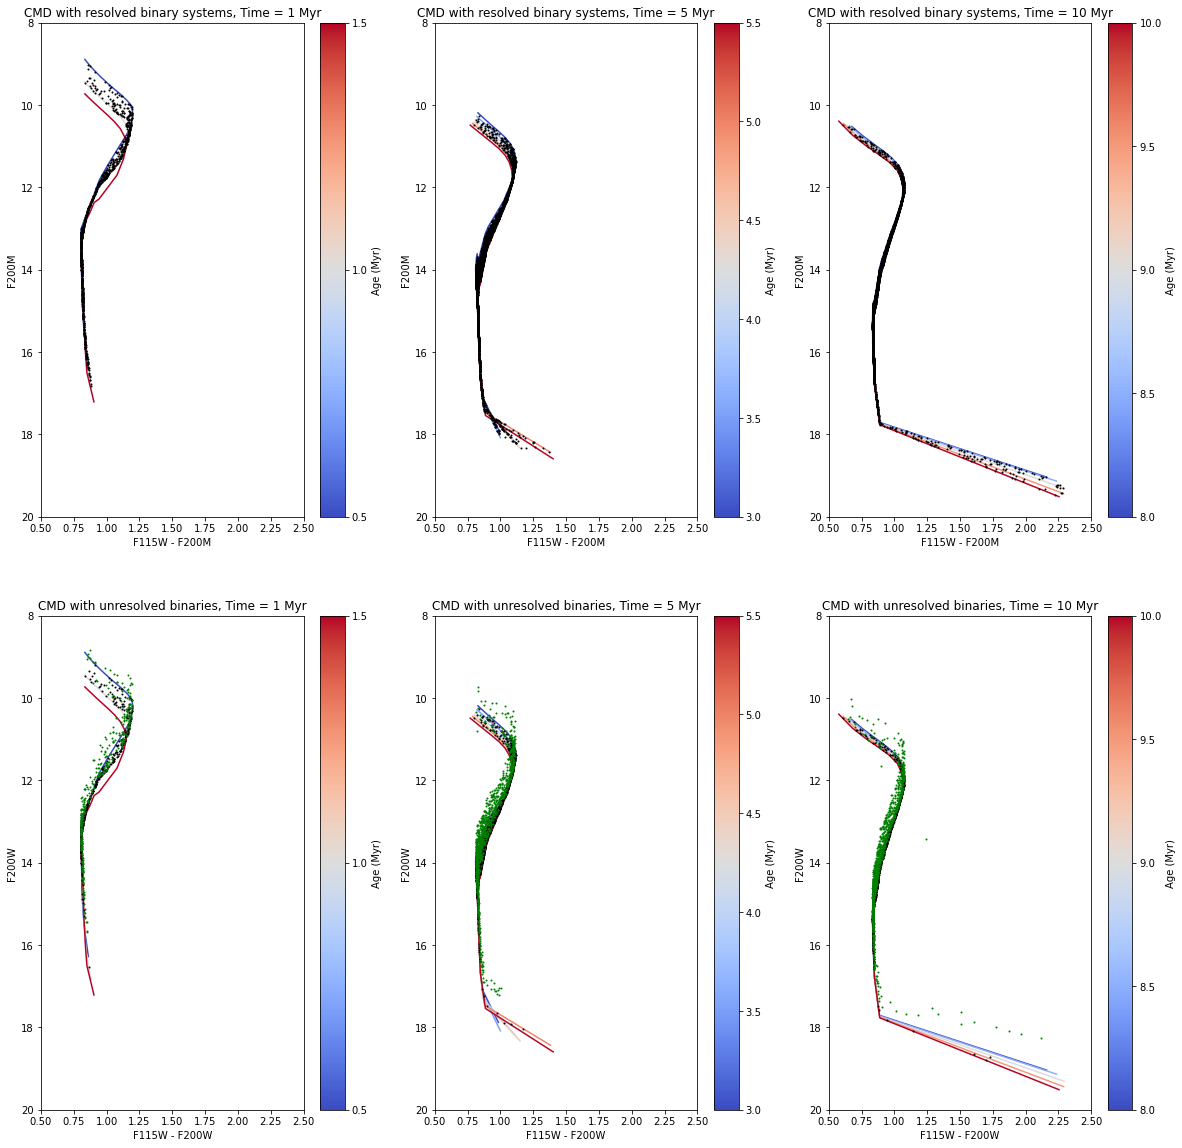

In [5]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff010_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [1, 5, 10]

xlim_min = 0.5
xlim_max = 2.5
ylim_min = 8
ylim_max = 20

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, 3, t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title('CMD with resolved binary systems, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, 3, t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title('CMD with unresolved binaries, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

/scratch/wyz5rge/synthetic-hr/interpolator.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  w1 = (np.power(10, age_arr[a2]) / 1000000 - age) / (np.power(10, age_arr[a2]) / 1000000 - np.power(10, age_arr[a1]) / 1000000)
/scratch/wyz5rge/synthetic-hr/interpolator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  s_lum = w1 * s1[1] + w2 * s2[1]
/scratch/wyz5rge/synthetic-hr/interpolator.py:100: RuntimeWarning: invalid value encountered in double_scalars
  s_teff = w1 * s1[2] + w2 * s2[2]
/scratch/wyz5rge/synthetic-hr/interpolator.py:101: RuntimeWarning: invalid value encountered in double_scalars
  s_logg = w1 * s1[3] + w2 * s2[3]
/scratch/wyz5rge/synthetic-hr/interpolator.py:102: RuntimeWarning: invalid value encountered in double_scalars
  s_filt1 = w1 * s1[4] + w2 * s2[4]
/scratch/wyz5rge/synthetic-hr/interpolator.py:103: RuntimeWarning: invalid value encountered in double_scalars
  s_filt2 = w1 * s1[5] + w2 * s2[5]


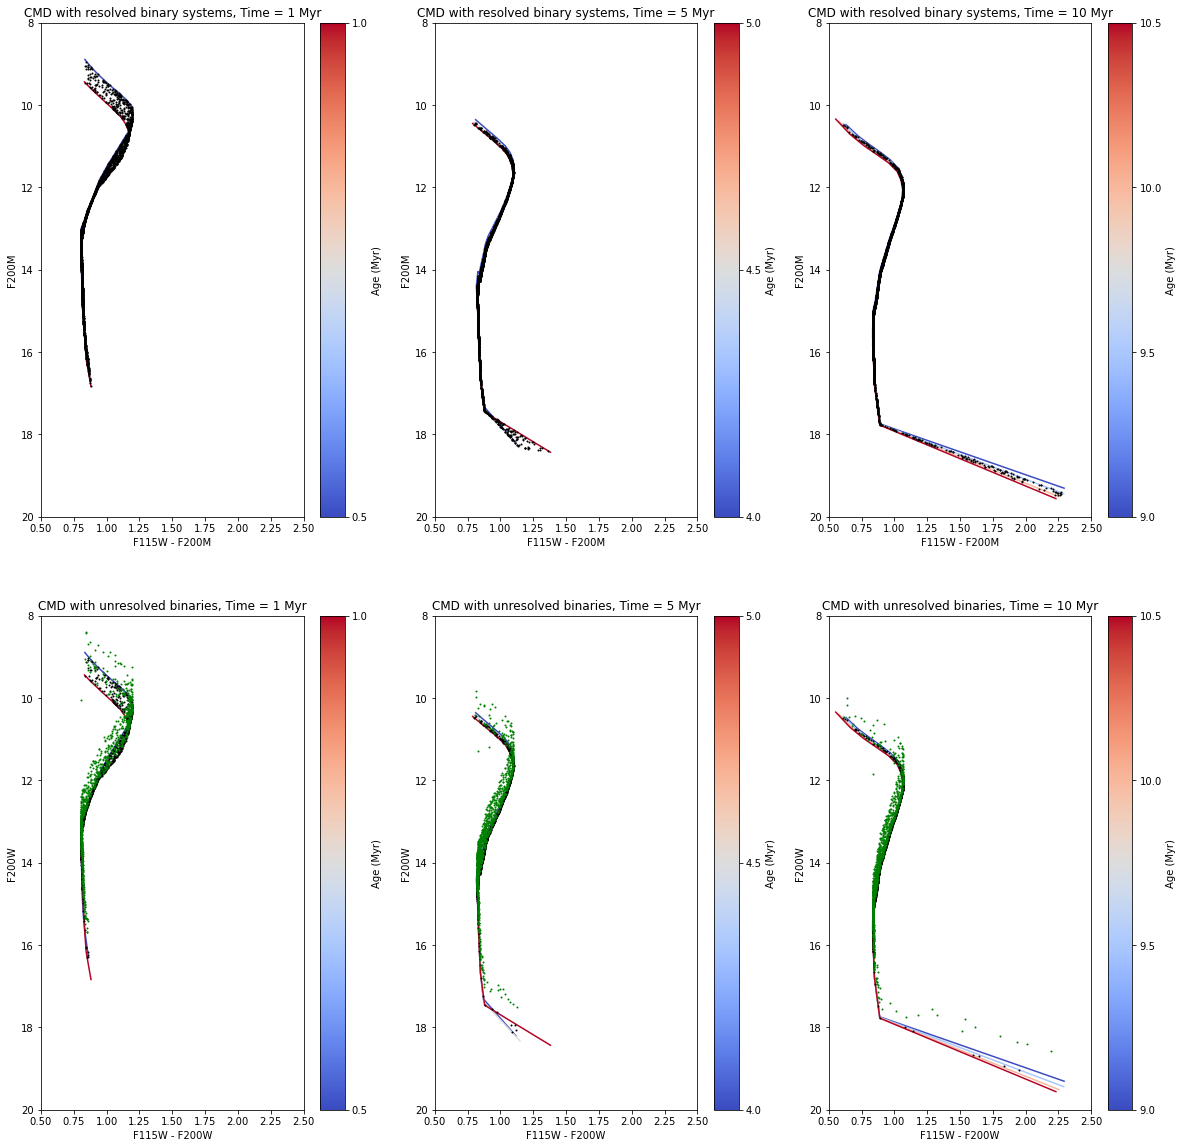

In [6]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff030_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [1, 5, 10]

xlim_min = 0.5
xlim_max = 2.5
ylim_min = 8
ylim_max = 20

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, 3, t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title('CMD with resolved binary systems, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, 3, t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title('CMD with unresolved binaries, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

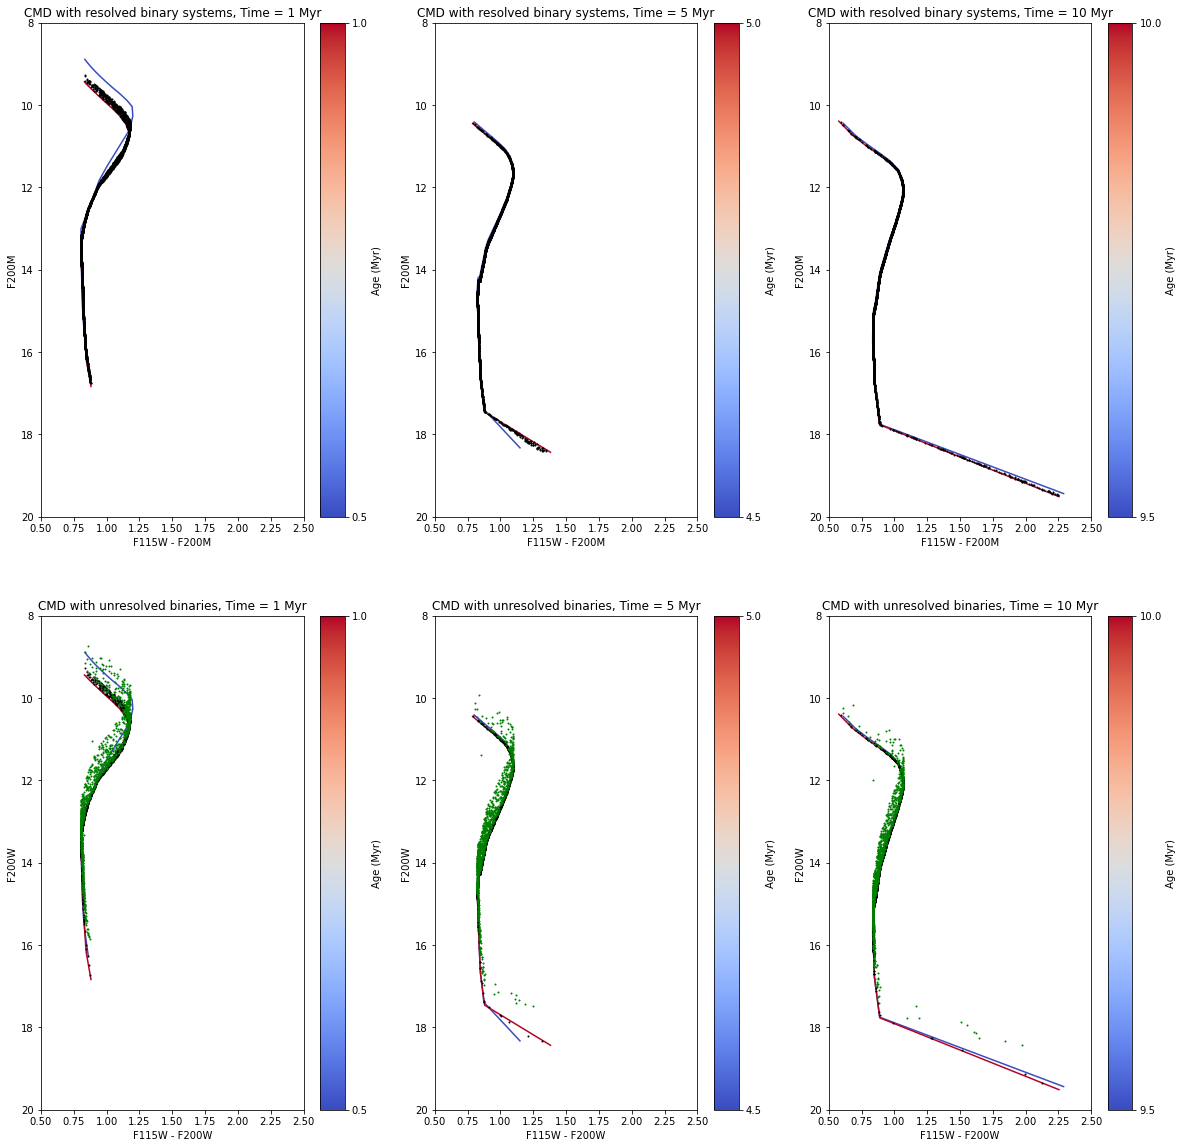

In [7]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff100_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [1, 5, 10]

xlim_min = 0.5
xlim_max = 2.5
ylim_min = 8
ylim_max = 20

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, 3, t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title('CMD with resolved binary systems, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, 3, t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title('CMD with unresolved binaries, Time = ' + str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])